In [1]:
from matplotlib import pyplot as plt
import numpy as np
from netCDF4 import Dataset
import netCDF4
import pickle
import cftime
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
#from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset



SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  import sys


In [2]:
# set constants
path='/storage/jlavoie/Research/Data/Budget/'
fTEMP=Dataset(path+'b.e11.BRCP85C5CNBDRD.f09_g16.002.pop.h.TEMP.200601-208012.nc')
fTEMP1=Dataset(path+'b.e11.B20TRC5CNBDRD.f09_g16.002.pop.h.TEMP.192001-200512.nc')
faice=Dataset(path+'b.e11.BRCP85C5CNBDRD.f09_g16.002.cice.h.aice_nh.200601-208012.nc')


months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
nbDaysInMonth=[31,28,31,30,31,30,31,31,30,31,30,31]


rho_sw=fTEMP['rho_sw'][:]*1000#kg m-3
cp_sw=fTEMP['cp_sw'][:]*0.0001#J kg-1 K-1
T2E=rho_sw*cp_sw#J degC-1 m-3 # convert temperature to energy density

latent_heat_vapor=fTEMP['latent_heat_vapor'][:]
latent_heat_fusion=fTEMP1['latent_heat_fusion'][:]*1e-7*1000# erg/g -> J/kg
rho_ice=917#kg/m3

dz=fTEMP['dz'][:]*0.01# m
dzw=fTEMP['dzw'][:]*0.01# m
Tf=-1.8
tlong=fTEMP['TLONG'][:]
tlat=fTEMP['TLAT'][:]
tlon=faice['TLON'][:]
tla=faice['TLAT'][:]
z_t=fTEMP['z_t'][:]*0.01#m
z_w=fTEMP['z_w'][:]*0.01#m
z_w_top=fTEMP['z_w_top'][:]*0.01#m
z_w_bot=fTEMP['z_w_bot'][:]*0.01#m


timeDay1=fTEMP1['time']
#fix month error in cesm
Jan1920=cftime.DatetimeNoLeap(1920, 1, 1, 0, 0, 0, 0, 0, 0)
time1 = netCDF4.num2date(timeDay1[:],timeDay1.units,calendar=timeDay1.calendar)
time1=[Jan1920]+list(time1[:-1])
time_boundDay1=fTEMP1['time_bound']
time_bound1 = netCDF4.num2date(time_boundDay1[:],timeDay1.units,calendar=timeDay1.calendar)
ind1970, ind1980= 600,720

timeDay=fTEMP['time']
time = netCDF4.num2date(timeDay[:],timeDay.units,calendar=timeDay.calendar)
#fix month error in cesm
Jan2006=cftime.DatetimeNoLeap(2006, 1, 1, 0, 0, 0, 0, 0, 0)
time=[Jan2006]+list(time[:-1])
time_boundDay=fTEMP['time_bound']
time_bound = netCDF4.num2date(time_boundDay[:],timeDay.units,calendar=timeDay.calendar)
ind2010,ind2020=12*4,12*14



# create mask of the Cananda Basin
# ocean (384,320)
maskCBocn=np.zeros((384,320))
for i in range(384):
    for j in range(320):
        if  205<=tlong[i,j]<=230 and 72<=tlat[i,j]<=80:
            maskCBocn[i,j]=1
#ice (384,320)         
maskCBice=np.zeros((104,320))
for i in range(104):
    for j in range(320):
        if  205<=tlon[i,j]<=230 and 72<=tla[i,j]<=80:
            maskCBice[i,j]=1


# heat budget (for figure 2-3)

In [11]:
pathCESM='/storage/jlavoie/Research/Data/CESM-LE/'

#list of string with numberof EM
EM=['00'+str(i) if i<10 else  '0'+str(i) if i<100 else ' '   for i in range(1,36)] +[str(i) for i in range(101,106)]
#cesm variable needed to calculate the flux of element of the budget
varByFlux={'deltaFsw':['QSW_3D'],
    'Fsens':['SENH_F'],'Fsw':['SHF_QSW','fswthru_ai'],'Fevap':['EVAP_F'],'Flw':['LWDN_F','LWUP_F'],'Ffrazil':['QFLUX'],
           'Fio':['MELTH_F'],'Fhor':['ADVT','HDIFT'],'Fsw,io':['fswthru_ai'],
           'Fct':['fcondtop_ai'],'Fcb':['congel','meltb','meltl','MELTH_F'],
           'Fsw,pen':['flat_ai','fsens_ai','flwup_ai','flwdn','aice','fswabs_ai','fsurf_ai'],
           'dEdt':['TEMP'],'SIC':['aice'],
           'Fsw,ai':['fswabs_ai'],'Flat,ai':['flat_ai'],'Fsens,ai':['fsens_ai'],'Flw,ai':['flwdn','aice','flwup_ai'],
           'dhdt_b,l':['meltl','meltb','congel'],'dhdt_f':['frazil'],'dhdt_s':['meltt']}

In [12]:
#for each EM calculate all variables than take mean of all
"""
#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std

budget_40=[{'deltaFsw':[],'Fsens':[],'Fsw':[],'Fevap':[],'Flw':[],'Ffrazil':[],'Fio':[],'Fhor':[],'Fsw,io':[],'Fct':[],
                    'Fcb':[],'Fsw,pen':[],'dEdt':[],'SIC':[],'Fsw,ai':[],'Flat,ai':[],'Fsens,ai':[],'Flw,ai':[],
                   'dhdt_b,l':[],'dhdt_f':[],'dhdt_s':[]},{'deltaFsw':[],'Fsens':[],'Fsw':[],'Fevap':[],'Flw':[],'Ffrazil':[],'Fio':[],'Fhor':[],'Fsw,io':[],'Fct':[],
                    'Fcb':[],'Fsw,pen':[],'dEdt':[],'SIC':[],'Fsw,ai':[],'Flat,ai':[],'Fsens,ai':[],'Flw,ai':[],
                   'dhdt_b,l':[],'dhdt_f':[],'dhdt_s':[]}]

timeBD=time_boundDay1[indA-1:indB+1]# get time for right window
DeltaTime=[(x[1]-x[0])*86400 for x in timeBD]# nb of days in the months and put in sec
budgetMean=[]
budgetStd=[]
budgetMax=[]
budgetMin=[]

for p in range(1,2):# iterate between 2 periods
    if p==0:
        indA,indB=ind1970,ind1980
        run='B20TRC5CNBDRD'
    else:
        indA,indB=ind2010,ind2020
        run='BRCP85C5CNBDRD'
    for em in EM: # iterate on each EM
        print(em)
        for f in budget_40[p]: # iterate through the fluxes we want to calculate
            if f=='deltaFsw' and em=='001':
                break
            varNeeded=[]
            for var in varByFlux[f]: # download the variables you need for the calculation of the flux f
                #specifics of filename
                model='pop'
                varHemi=var
                if var[0].islower():
                    model='cice'
                    varHemi=var+'_nh'#add hemisphere for name of file
                push1920=0
                if p==0:
                    if em=='001':
                        date='185001-200512'
                        push1920=840#push index to start at 1920 not 1850
                            
                    else:
                        date='192001-200512'          
                else:
                    if int(em)>=34 and p==1:
                        date='200601-210012'
                    else:
                        date='200601-208012'
                        
                fileEM=Dataset(pathCESM+var+'/b.e11.'+run+'.f09_g16.'+em+'.'+model+'.h.'+varHemi+'.'+date+'.nc')
                if em=='001':
                    varNeeded.append(fileEM[var][840:])
                elif f=='deltaFsw':
                    cutVar=fileEM[var][indA+push1920:indB+push1920,:,-104:]# cut like this because it is faster
                    varNeeded.append(cutVar[:,:,maskCBice==1])
                else:
                    varNeeded.append(fileEM[var][:])




            #mean 1970-1979 and CB
            if f=='Fevap':# need to multiply by latent heat
                #avg over years and position
                dataVar_CB=np.nanmean([varNeeded[0][indA+m:indB+m:12][:,maskCBocn==1]*latent_heat_vapor
                                                    for m in range(12)],axis=(1,2))
            elif f=='Fhor':#transform from cm C s-1 to W m-2
                dataVar_CB=np.nanmean([varNeeded[0][indA+m:indB+m:12][:,maskCBocn==1]*T2E/100
                                                +varNeeded[1][indA+m:indB+m:12][:,maskCBocn==1]*T2E/100
                                                for m in range(12)],axis=(1,2))
            elif f=='Flw':
                dataVar_CB=np.nanmean([varNeeded[0][indA+m:indB+m:12][:,maskCBocn==1]
                                                +varNeeded[1][indA+m:indB+m:12][:,maskCBocn==1]
                                                for m in range(12)],axis=(1,2))
            elif f=='Fsw':
                dataVar_CB=np.nanmean([varNeeded[0][indA+m:indB+m:12][:,maskCBocn==1]
                                                -varNeeded[1][indA+m:indB+m:12][:,maskCBice==1]
                                                for m in range(12)],axis=(1,2))
            elif f=='Flw,ai':
                dataVar_CB=np.nanmean([(varNeeded[0][indA+m:indB+m:12][:,maskCBice==1]
                                                *varNeeded[1][indA+m:indB+m:12][:,maskCBice==1]/100)
                                                +varNeeded[2][indA+m:indB+m:12][:,maskCBice==1]
                                                for m in range(12)],axis=(1,2))
            elif f=='dhdt_b,l':# if lower case=> on ice grid
                dataVar_CB=np.nanmean([-varNeeded[0][indA+m:indB+m:12][:,maskCBice==1]
                                                -varNeeded[1][indA+m:indB+m:12][:,maskCBice==1]
                                                +varNeeded[2][indA+m:indB+m:12][:,maskCBice==1]
                                                for m in range(12)],axis=(1,2))*nbDaysInMonth
            elif f[:4]=='dhdt':
                dataVar_CB=np.nanmean([varNeeded[0][indA+m:indB+m:12][:,maskCBice==1]
                                                for m in range(12)],axis=(1,2))*nbDaysInMonth
            elif f=='dEdt':
                E_sumDepth=np.nansum(np.nanmean(varNeeded[0][indA-1:indB+1][:,:,maskCBocn==1],axis=(2))*dz*T2E,axis=1)
                wAvgTemp=[((E_sumDepth[i]*DeltaTime[i]) + (E_sumDepth[i+1]*DeltaTime[i+1]))/(DeltaTime[i]+DeltaTime[i+1]) for i in range(121)]
                dEdt_sumDepth=[(wAvgTemp[i]-wAvgTemp[i-1])/DeltaTime[i] for i in range(1,121)]
                dataVar_CB=np.nanmean([dEdt_sumDepth[m::12] for m in range(12)],axis=1)

            elif f=='Fcb':
                dhdtb=(varNeeded[0][indA:indB][:,maskCBice==1]-varNeeded[1][indA:indB][:,maskCBice==1])/100/86400 # m/s
                meltl=varNeeded[2][indA:indB][:,maskCBice==1]/100/86400 # m/s
                Fmeltb=varNeeded[3][indA:indB][:,maskCBocn==1]-(-latent_heat_fusion*rho_ice*meltl)
                condbot_est=(-dhdtb*latent_heat_fusion*rho_ice)+Fmeltb
                dataVar_CB=np.nanmean([condbot_est[m::12]for m in range(12)],axis=(1,2))

            elif f=='Fsw,pen':
                pen=(varNeeded[0]+varNeeded[1]+varNeeded[2]+(varNeeded[3]*varNeeded[4]/100)+varNeeded[5]-varNeeded[6])
                dataVar_CB=np.nanmean([pen[indA+m:indB+m:12][:,maskCBice==1]for m in range(12)],axis=(1,2))

            elif f=='deltaFsw':
                #(Fsw(z=0) - Fsw(z=10) )
                dataVar_CB=np.nanmean([(varNeeded[0][m::12,0]-varNeeded[0][m::12,1]) for m in range(12)],axis=(1,2))
    
            elif var[0].islower():# if lower case=> on ice grid
                dataVar_CB=np.nanmean([varNeeded[0][indA+m:indB+m:12][:,maskCBice==1]
                                                for m in range(12)],axis=(1,2))
                
            else:
                dataVar_CB=np.nanmean([varNeeded[0][indA+m:indB+m:12][:,maskCBocn==1]
                                                for m in range(12)],axis=(1,2))
            budget_40[p][f].append(dataVar_CB)

    for f in budget_40[p]:
        budget_40[p][f]=np.array(budget_40[p][f])
    budget_40[p]['residual']=budget_40[p]['dEdt']-(budget_40[p]['Fsw']+budget_40[p]['Flw']+
                                                              budget_40[p]['Fsens']+budget_40[p]['Fevap']+
                                                              budget_40[p]['Fio']+budget_40[p]['Fhor']+
                                                              budget_40[p]['Fsw,io']+budget_40[p]['Ffrazil'])
    
    budget_40[p]['R']=(budget_40[p]['Fevap']+budget_40[p]['Fsens']+budget_40[p]['Ffrazil']+budget_40[p]['Flw']+
                        budget_40[p]['deltaFsw'])
    

    # mean, std, min,max over the 40 ems
    meanB={}
    stdB={}
    maxB={}
    minB={}
    for f in budget_40[p]:
        meanB[f]=np.nanmean(budget_40[p][f],axis=0)
        stdB[f]=np.nanstd(budget_40[p][f],axis=0)
        maxB[f]=np.nanmax(budget_40[p][f],axis=0)
        minB[f]=np.nanmin(budget_40[p][f],axis=0)
    budgetMean.append(meanB)
    budgetStd.append(stdB)
    budgetMax.append(maxB)
    budgetMin.append(minB)
"""

"\n#dictionnary where we store (40em,12 months) for each flux, before calculating mean and std\n\nbudget_40=[{'deltaFsw':[],'Fsens':[],'Fsw':[],'Fevap':[],'Flw':[],'Ffrazil':[],'Fio':[],'Fhor':[],'Fsw,io':[],'Fct':[],\n                    'Fcb':[],'Fsw,pen':[],'dEdt':[],'SIC':[],'Fsw,ai':[],'Flat,ai':[],'Fsens,ai':[],'Flw,ai':[],\n                   'dhdt_b,l':[],'dhdt_f':[],'dhdt_s':[]},{'deltaFsw':[],'Fsens':[],'Fsw':[],'Fevap':[],'Flw':[],'Ffrazil':[],'Fio':[],'Fhor':[],'Fsw,io':[],'Fct':[],\n                    'Fcb':[],'Fsw,pen':[],'dEdt':[],'SIC':[],'Fsw,ai':[],'Flat,ai':[],'Fsens,ai':[],'Flw,ai':[],\n                   'dhdt_b,l':[],'dhdt_f':[],'dhdt_s':[]}]\n\ntimeBD=time_boundDay1[indA-1:indB+1]# get time for right window\nDeltaTime=[(x[1]-x[0])*86400 for x in timeBD]# nb of days in the months and put in sec\nbudgetMean=[]\nbudgetStd=[]\nbudgetMax=[]\nbudgetMin=[]\n\nfor p in range(1,2):# iterate between 2 periods\n    if p==0:\n        indA,indB=ind1970,ind1980\n        run='

In [13]:
# save results of code above to avoid having to rerun it
"""
with open('saved/budgetMean.pickle', 'wb') as handle:
    pickle.dump(budgetMean, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('saved/budgetStd.pickle', 'wb') as handle:
    pickle.dump(budgetStd, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('saved/budgetMax.pickle', 'wb') as handle:
    pickle.dump(budgetMax, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('saved/budgetMin.pickle', 'wb') as handle:
    pickle.dump(budgetMin, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""

with open('saved/budgetMean.pickle', 'rb') as handle:
    budgetMean = pickle.load(handle)

with open('saved/budgetStd.pickle', 'rb') as handle:
    budgetStd = pickle.load(handle)
    
with open('saved/budgetMax.pickle', 'rb') as handle:
    budgetMax = pickle.load(handle)

with open('saved/budgetMin.pickle', 'rb') as handle:
    budgetMin = pickle.load(handle)

In [14]:
years=['1970-1979','2010-2019']
for p in range(2):
    print('July '+years[p])
    for f in budgetMean[p]:
        print('%s = %0.2f ± %1.2f '%(f,budgetMean[p][f][6],budgetStd[p][f][6]))
    print(' ')
    
for p in range(2):
    print('Feb '+years[p])
    for f in budgetMean[p]:
        print('%s = %0.2f ± %1.2f '%(f,budgetMean[p][f][1],budgetStd[p][f][1]))



July 1970-1979
deltaFsw = 24.93 ± 2.52 
Fsens = 0.11 ± 0.10 
Fsw = 29.77 ± 2.98 
Fevap = -0.04 ± 0.08 
Flw = -4.14 ± 0.56 
Ffrazil = 0.00 ± 0.00 
Fio = -22.74 ± 1.94 
Fhor = 1.90 ± 0.79 
Fsw,io = 5.69 ± 0.94 
Fct = -1.64 ± 0.25 
Fcb = 0.79 ± 0.70 
Fsw,pen = 33.27 ± 3.46 
dEdt = 9.22 ± 1.76 
SIC = 87.87 ± 1.27 
Fsw,ai = 86.59 ± 4.96 
Flat,ai = -3.57 ± 0.33 
Fsens,ai = 2.22 ± 0.33 
Flw,ai = -31.25 ± 1.61 
dhdt_b,l = -20.59 ± 2.21 
dhdt_f = 0.00 ± 0.00 
dhdt_s = 20.93 ± 3.89 
residual = -1.33 ± 0.52 
R = 20.86 ± 2.13 
 
July 2010-2019
deltaFsw = 37.09 ± 5.15 
Fsens = 0.59 ± 0.15 
Fsw = 40.40 ± 5.54 
Fevap = 0.27 ± 0.13 
Flw = -4.68 ± 0.71 
Ffrazil = 0.00 ± 0.00 
Fio = -31.94 ± 2.73 
Fhor = 4.13 ± 0.90 
Fsw,io = 12.18 ± 2.35 
Fct = -1.05 ± 0.22 
Fcb = 5.69 ± 1.57 
Fsw,pen = 47.13 ± 3.22 
dEdt = 19.15 ± 4.51 
SIC = 81.38 ± 2.96 
Fsw,ai = 102.06 ± 4.92 
Flat,ai = -2.67 ± 0.39 
Fsens,ai = 2.82 ± 0.38 
Flw,ai = -26.58 ± 2.09 
dhdt_b,l = -32.94 ± 3.67 
dhdt_f = 0.00 ± 0.00 
dhdt_s = 39.28 ± 4.6

# seasonal cycle R(z=5m) (figure 12)

/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


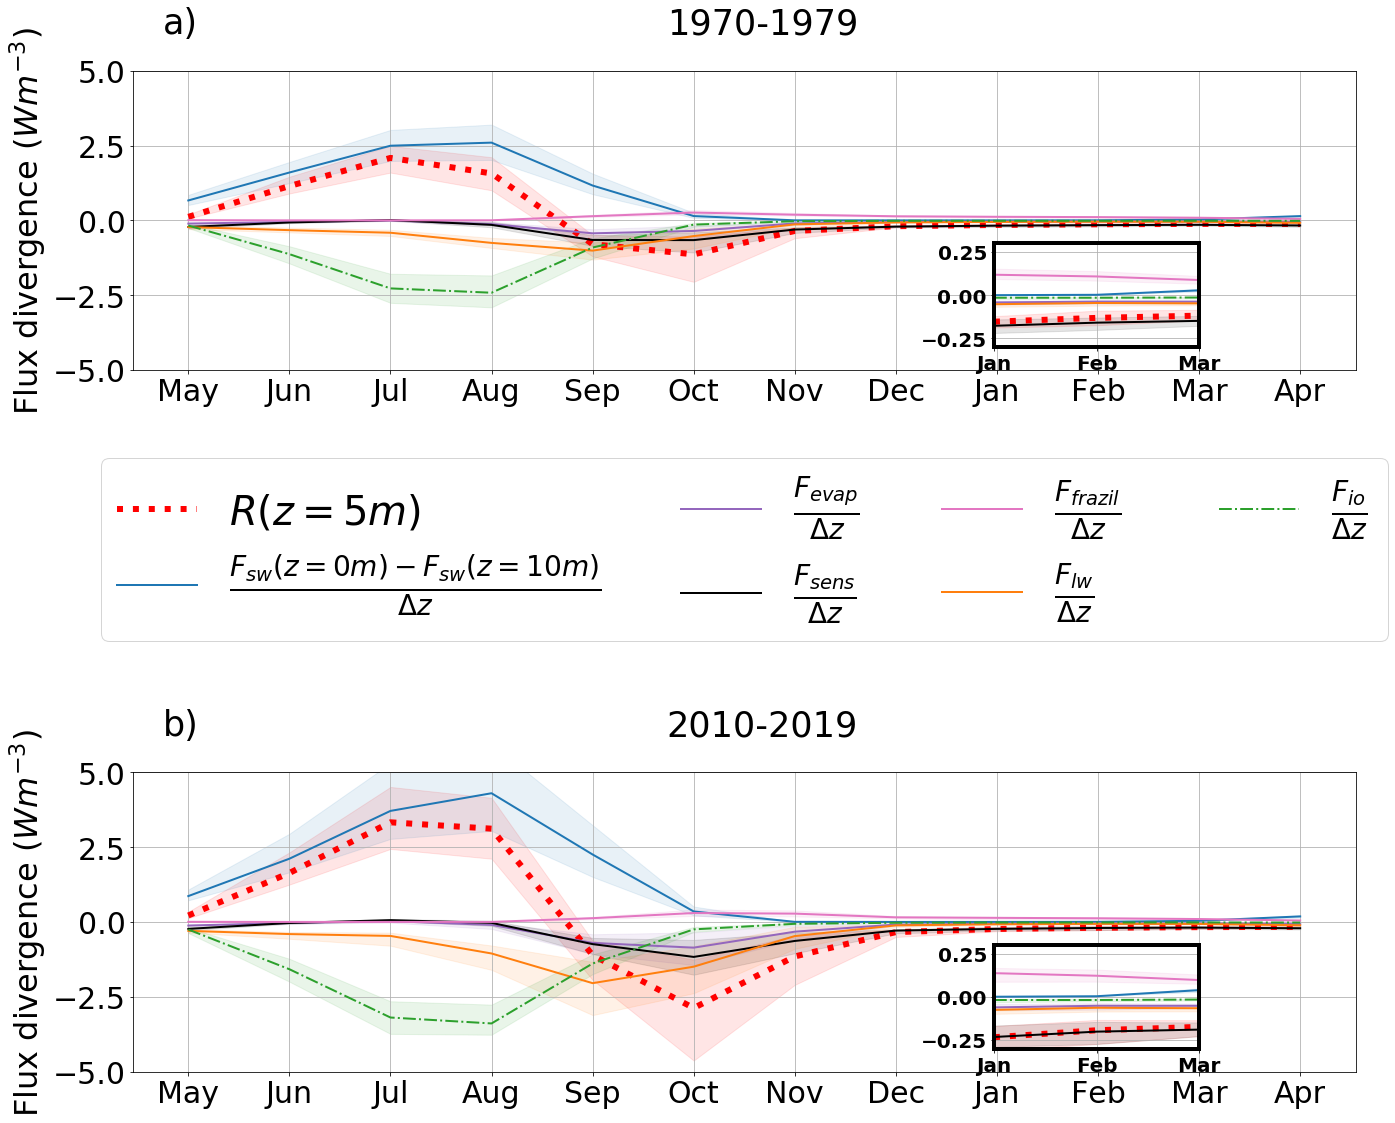

In [15]:
alpha=0.1
fig,axs=plt.subplots(2,1,figsize=(20,15))
#axins=[inset_axes(ax, 2.945,1.8, loc='upper right',bbox_to_anchor=(0.8785,0.45),bbox_transform=ax.transAxes) for ax in axs]
axins=[inset_axes(ax, 2.85,1.8*0.8, loc='upper right',bbox_to_anchor=(0.8785,0.45),bbox_transform=ax.transAxes) for ax in axs]

for ax in axs:
    ax.set_ylabel('Flux divergence ($W m^{-3}$)', fontsize=32)
    ax.grid()
    ax.set_ylim(-5,5)
for axi in axins:
    axi.set_ylim(-0.3,0.3)
    axi.set_xlim(8,10)
    axi.set_xticks([8,9,10])
    axi.grid()
    axi.set_xticklabels(['Jan','Feb','Mar'])

    for axis in ['top','bottom','left','right']:
        axi.spines[axis].set_linewidth(4)
        axi.spines[axis].set_color('black')
    for tick in axi.xaxis.get_major_ticks():
        tick.label1.set_fontweight('bold')
    for tick in axi.yaxis.get_major_ticks():
        tick.label1.set_fontweight('bold')
    


fR=['R','deltaFsw','Fevap','Fsens','Ffrazil','Flw','Fio']
labR=['$R (z=5m)$',r'$\frac{F_{sw}(z=0m)-F_{sw}(z=10m)}{\Delta z}$',r'$\frac{ F_{evap}}{\Delta z}$',r'$\frac{ F_{sens}}{\Delta z}$ ',r'$ \frac{ F_{frazil}}{\Delta z}$  '
      ,r'$\frac{ F_{lw}}{\Delta z}$ ',r'$\frac{ F_{io}}{\Delta z}$ ']
colorR=['red','tab:blue','tab:purple','black','tab:pink','tab:orange','tab:green']
linestyleR=[':','-','-','-','-','-','-.']
linewidthR=[6,2,2,2,2,2,2]
for p in range(2):
    for f,label,c,ls,lw in zip(fR,labR,colorR,linestyleR,linewidthR):
        axs[p].plot(months[4:]+months[:4],(list(budgetMean[p][f][4:])+list(budgetMean[p][f][:4]))/dz[0]
        , linewidth=lw,color=c,label=label,linestyle=ls)
        axins[p].plot([8,9,10],(list(budgetMean[p][f][:3]))/dz[0], linewidth=lw,alpha=1,color=c,linestyle=ls)

        axs[p].fill_between(months[4:]+months[:4],(list(budgetMin[p][f][4:])+list(budgetMin[p][f][:4]))/dz[0],
                            (list(budgetMax[p][f][4:])+list(budgetMax[p][f][:4]))/dz[0],alpha=alpha,color=c)
        axins[p].fill_between([8,9,10],(list(budgetMin[p][f][:3]))/dz[0],(list(budgetMax[p][f][:3]))/dz[0]
                             ,alpha=alpha,color=c)
        
        axs[p].tick_params(axis='both', which='major', labelsize=30)
        axins[p].tick_params(axis='both', which='major', labelsize=20)
axs[0].legend(ncol=4,loc='center',bbox_to_anchor=(0.5,-0.6),fontsize=40)
fig.text(0.45, 0.37, '2010-2019', va='center',fontsize=35)
fig.text(0.45, 1.02, '1970-1979', va='center',fontsize=35)
fig.text(0.1, 0.37, 'b)', va='center',fontsize=35)
fig.text(0.1, 1.02, 'a)', va='center',fontsize=35)
fig.tight_layout(h_pad=5)


# sea ice mass balance integrated over the year

In [8]:
# calculate different types of melt and growth over a year
#1970s
varByFlux['total surf melt']=['meltt']
varByFlux['total basal melt']=['meltb','meltl']
varByFlux['total basal growth']=['congel']
varByFlux['summer dynamic']=['dvidtd']
varByFlux['winter dynamic']=['dvidtd']
winterIdx=[8,9,10,11,1,2,3,4]
indA,indB=ind1970, ind1980
ice_19701979_40={'total surf melt':[],'total basal melt':[],'total basal growth':[],'summer dynamic':[]
                 ,'winter dynamic':[]}
for em in EM:
    print(em)
    for f in ice_19701979_40:
        varNeeded=[]
        for var in varByFlux[f]:
            #specifics of filename
            date='192001-200512'
            model='cice'
            varHemi=var+'_nh'#add hemisphere for name of file
            if em=='001':
                date='185001-200512'
            fileEM=Dataset(pathCESM+var+'/b.e11.B20TRC5CNBDRD.f09_g16.'+em+'.'+model+'.h.'+varHemi+'.'+date+'.nc')
            if em=='001':
                varNeeded.append(fileEM[var][840:])
            else:
                varNeeded.append(fileEM[var][:])
            
        
        if f== 'total basal melt':
            dataVar_19701979_CB=np.nanmean(np.nansum([(varNeeded[0][indA+m:indB+m:12][:,maskCBice==1]
                                            +varNeeded[1][indA+m:indB+m:12][:,maskCBice==1])*nbDaysInMonth[m]
                                            for m in range(12)],axis=0),axis=(0,1))
        elif f=='summer dynamic':
            dataVar_19701979_CB=np.nanmean(np.nansum([(varNeeded[0][indA+m:indB+m:12][:,maskCBice==1])*nbDaysInMonth[m]
                                            for m in range(12)][5:8],axis=0),axis=(0,1))
        elif f=='winter dynamic':
            dataVar_19701979_CB=np.nanmean(np.nansum([[(varNeeded[0][indA+m:indB+m:12][:,maskCBice==1])*nbDaysInMonth[m]
                                            for m in range(12)][i] for i in winterIdx],axis=0),axis=(0,1))

        else:# if lower case=> on ice grid
            dataVar_19701979_CB=np.nanmean(np.nansum([varNeeded[0][indA+m:indB+m:12][:,maskCBice==1]*nbDaysInMonth[m]
                                            for m in range(12)],axis=0),axis=(0,1))

        ice_19701979_40[f].append(dataVar_19701979_CB)

for f in ice_19701979_40:
    ice_19701979_40[f]=np.array(ice_19701979_40[f])
ice_19701979={}
iceSTD_19701979={}
for f in ice_19701979_40:
    ice_19701979[f]=np.nanmean(ice_19701979_40[f],axis=0)
    iceSTD_19701979[f]=np.nanstd(ice_19701979_40[f],axis=0)

001
002
003
004
005
006


KeyboardInterrupt: 

In [9]:
# same as cell above but for 2010s
indA,indB=ind2010, ind2020
ice_20102019_40={'total surf melt':[],'total basal melt':[],'total basal growth':[],'summer dynamic':[]
                 ,'winter dynamic':[]}
for em in EM:
    print(em)
    for f in ice_20102019_40:
        varNeeded=[]
        for var in varByFlux[f]:
            #specifics of filename
            date='200601-208012'
            model='cice'
            varHemi=var+'_nh'#add hemisphere for name of file
            if int(em)>=34:
                date='200601-210012'
            fileEM=Dataset(pathCESM+var+'/b.e11.BRCP85C5CNBDRD.f09_g16.'+em+'.'+model+'.h.'+varHemi+'.'+date+'.nc')
            if int(em)>=34:
                varNeeded.append(fileEM[var][:-240])
            else:
                varNeeded.append(fileEM[var][:])
            
        
        if f== 'total basal melt':
            dataVar_20102019_CB=np.nanmean(np.nansum([(varNeeded[0][indA+m:indB+m:12][:,maskCBice==1]
                                            +varNeeded[1][indA+m:indB+m:12][:,maskCBice==1])*nbDaysInMonth[m]
                                            for m in range(12)],axis=0),axis=(0,1))
        elif f=='summer dynamic':
            dataVar_20102019_CB=np.nanmean(np.nansum([(varNeeded[0][indA+m:indB+m:12][:,maskCBice==1])*nbDaysInMonth[m]
                                            for m in range(12)][5:8],axis=0),axis=(0,1))
        elif f=='winter dynamic':
            dataVar_20102019_CB=np.nanmean(np.nansum([[(varNeeded[0][indA+m:indB+m:12][:,maskCBice==1])*nbDaysInMonth[m]
                                            for m in range(12)][i] for i in winterIdx],axis=0),axis=(0,1))

        else:# if lower case=> on ice grid
            dataVar_20102019_CB=np.nanmean(np.nansum([varNeeded[0][indA+m:indB+m:12][:,maskCBice==1]*nbDaysInMonth[m]
                                            for m in range(12)],axis=0),axis=(0,1))

        ice_20102019_40[f].append(dataVar_20102019_CB)

for f in ice_20102019_40:
    ice_20102019_40[f]=np.array(ice_20102019_40[f])
ice_20102019={}
iceSTD_20102019={}
for f in ice_20102019_40:
    ice_20102019[f]=np.nanmean(ice_20102019_40[f],axis=0)
    iceSTD_20102019[f]=np.nanstd(ice_20102019_40[f],axis=0)

001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
101
102
103
104
105


In [10]:
print('1970-1979')
for f in ice_19701979:
    print('%s = %0.2f ± %1.2f '%(f,ice_19701979[f],iceSTD_19701979[f]))
print('20102019')
for f in ice_20102019:
    print('%s = %0.2f ± %1.2f '%(f,ice_20102019[f],iceSTD_20102019[f]))

1970-1979
total surf melt = 33.78 ± 5.82 
total basal melt = 60.11 ± 7.14 
total basal growth = 115.21 ± 5.46 
summer dynamic = -3.73 ± 7.25 
winter dynamic = -30.02 ± 11.26 
20102019
total surf melt = 61.92 ± 6.73 
total basal melt = 97.64 ± 7.95 
total basal growth = 136.29 ± 7.92 
summer dynamic = -1.96 ± 7.09 
winter dynamic = 7.58 ± 7.90 


# growth of thick ice only

In [11]:
#1970s growth of thick ice
alldeltah=[]
for em in EM[1:]:
    deltahs=[]
    for c in range(4,6):
        cs=str(c)
        fvicen00c=Dataset(pathCESM+'vicen00'+cs+'/b.e11.B20TRC5CNBDRD.f09_g16.'+em+'.cice.h.vicen00'+cs+'_nh.192001-200512.nc')
        vicen00c=np.nanmean([fvicen00c['vicen00'+cs][ind1970:ind1980][m::12,maskCBice==1]for m in range(12)],axis=(1,2))
        deltah=np.max(vicen00c)-np.min(vicen00c)
        deltahs.append(deltah)
    alldeltah.append(deltahs)
alldeltah=np.array(alldeltah) 
print(alldeltah.shape)
print('mean: ', np.mean(alldeltah,axis=0))
print('std:',  np.std(alldeltah,axis=0))


(39, 2)
mean:  [0.35070637 0.50397503]
std: [0.09419167 0.06848466]


In [12]:
np.mean([0.35070637, 0.50397503]), np.sqrt(0.09419167**2+ 0.06848466**2)/2

(0.4273407, 0.0582284710272915)

In [13]:
#2010s growth of thick ice
alldeltah=[]
for em in EM:
    deltahs=[]
    for c in range(4,6):
        cs=str(c)
        enddate='208012'
        if int(em)>33:
            enddate='210012'
        fvicen00c=Dataset(pathCESM+'vicen00'+cs+'/b.e11.BRCP85C5CNBDRD.f09_g16.'+em+'.cice.h.vicen00'+cs+'_nh.200601-'+enddate+'.nc')
        vicen00c=np.nanmean([fvicen00c['vicen00'+cs][ind2010:ind2020][m::12,maskCBice==1]for m in range(12)],axis=(1,2))
        deltah=np.max(vicen00c)-np.min(vicen00c)
        deltahs.append(deltah)
    alldeltah.append(deltahs)
alldeltah=np.array(alldeltah) 
print(alldeltah.shape)
print('mean: ', np.mean(alldeltah,axis=0))
print('std:',  np.std(alldeltah,axis=0))

(40, 2)
mean:  [0.56981725 0.38866577]
std: [0.12985104 0.05054464]


In [14]:
np.mean([0.56981725, 0.38866577]), np.sqrt( 0.12985104**2+ 0.05054464**2)/2

(0.47924151000000004, 0.06967074928155144)